# Notebook to train CNNs

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, accuracy_score, recall_score
from data_utils_torch import get_paths_and_labels, calculate_min_max, create_dataloader, extract_subject_id
from plotting_utils_torch import view_image, view_random_image, plot_loss_curves, make_confusion_matrix, view_image_data
from sklearn.model_selection import StratifiedGroupKFold
import gc
from tqdm.auto import tqdm
from monai.networks.nets import ResNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility    
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Set mixed precision     
USE_AMP = True if device.type == 'cuda' else False
scaler = GradScaler(enabled=USE_AMP)
print(f"Automatic Mixed Precision (AMP) enabled: {USE_AMP}")

/home/diogommiranda/tese/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-06 22:03:28.896002: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-06 22:03:29.769051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cuda
Automatic Mixed Precision (AMP) enabled: True


In [2]:
NORMALIZATION = "mni_reg_CV" # Choose intensity normalization method: "minmax"
DATASET = "smci_pmci" # Choose dataset: "smci_pmci" or "nc_ad"
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET images
BATCH_SIZE = 4 # Set batch size

USE_MASK = False # Set to True to use the ROI mask, False to use the whole brain

if USE_MASK:
    ROI_MASK_PATH = str(Path("/home/diogommiranda/tese/masks/ROI_MASK.nii"))
else:
    ROI_MASK_PATH = None

# Get train paths and labels to calculate minmax values
train_paths, train_labels, class_map = get_paths_and_labels(DATA_DIR, 'train')
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

# Calculate minmax values for train set
minmax_min, minmax_max = calculate_min_max(train_paths)

# Create train dataset
train_data = create_dataloader(
    paths=train_paths,
    labels=train_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max, 
    mask_path=ROI_MASK_PATH
    )

# Create test set with the minmax values from train
test_paths, test_labels, _ = get_paths_and_labels(DATA_DIR, 'test', class_map=class_map)
test_data = create_dataloader(
    paths=test_paths,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=False,
    seed=None,
    min_val=minmax_min, 
    max_val=minmax_max,
    mask_path=ROI_MASK_PATH
    )

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/train...
    Found 575 files for class 'smci'
    Found 314 files for class 'pmci'
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/test...
    Found 143 files for class 'smci'
    Found 78 files for class 'pmci'


torch.Size([1, 91, 109, 91])


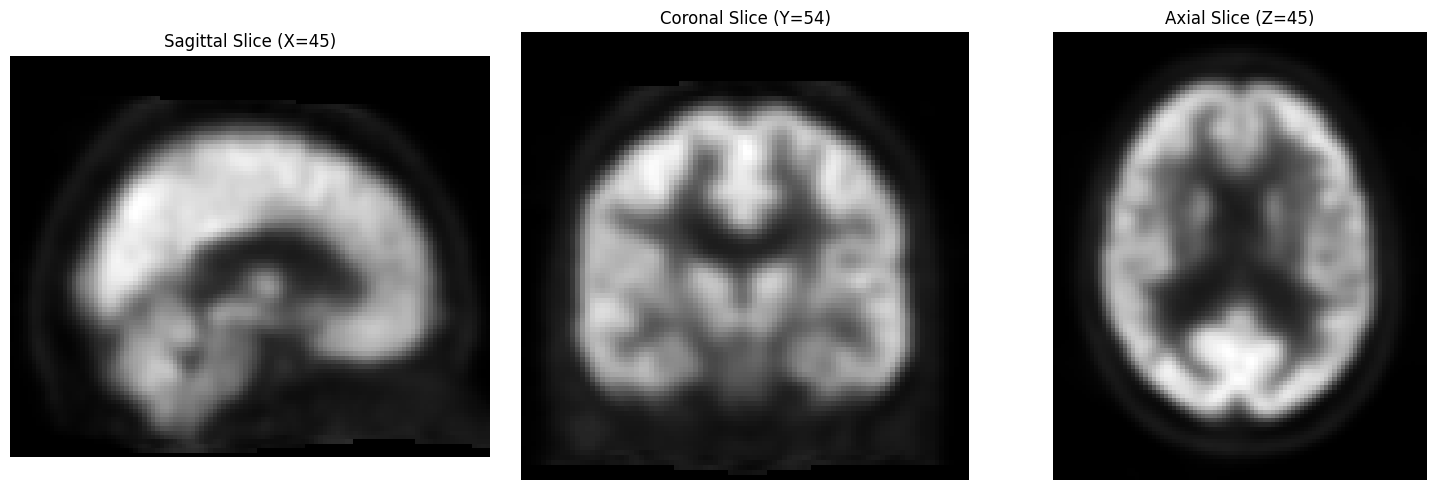

In [8]:
# Verify data with a test sample
i = 2
for data, label in test_data:
    view_image_data(data[i])
    #data[i] = torch.flip(data[i], dims=[3])
    #view_image_data(data[i])
    print(data[i].shape)
    break

In [9]:
# ----- Hyperparameter Tuning with K-Fold Cross-Validation -----

N_SPLITS = 5 # Number of splits for cross-validation

# para cosine decay
#learning_rates = [5e-4, 2e-4, 1e-4] # adicionar 1e-3? ver os resultados
#weight_decays = [5e-4, 2e-4, 1e-4]

#para fixed_lr
#learning_rates = [1e-5, 2e-5] # adicionar 4e-5 ou 5e-6 dependendo dos resultados
#weight_decays = [2e-4, 1e-4] # adicionar 4e-4 ou 5e-5 dependendo dos resultados

lr_scheduler = "fixed_lr" # Choose between "cosine_decay" or "fixed_lr"

if lr_scheduler == "cosine_decay":
    NUM_EPOCHS = 100
else:
    NUM_EPOCHS = 100

learning_rates = [1e-5]
weight_decays = [2e-4]

tuning_results = []
total_combinations = len(learning_rates) * len(weight_decays)
current_combination_no = 0

if ROI_MASK_PATH is None:
    if lr_scheduler == "cosine_decay":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/full_brain/cosine_decay/CROSS_VALIDATION/results_resnet34/"
    elif lr_scheduler == "fixed_lr":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/full_brain/fixed_lr/CROSS_VALIDATION/results_resnet34/"
    else:
        raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
    os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
    print(f"Results will be saved to: {RESULTS_BASE_DIR}")
else:
    if lr_scheduler == "cosine_decay":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/masked/cosine_decay/CROSS_VALIDATION/results_resnet34/"
    elif lr_scheduler == "fixed_lr":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/masked/fixed_lr/CROSS_VALIDATION/results_resnet34/"
    else:
        raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
    os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
    print(f"Results will be saved to: {RESULTS_BASE_DIR}")

# Set up StratifiedGroupKFold by subjects
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
subject_ids_list = [extract_subject_id(p) for p in train_paths]
subject_ids = np.array(subject_ids_list)

print("\nStarting Hyperparameter Tuning Grid Search...")
overall_start_time = time.time()

# Hyperparameter tuning loop
for current_lr in learning_rates:
    for current_wd in weight_decays: 
        current_combination_no += 1
        print("=" * 60)
        print(f"Testing Combination {current_combination_no}/{total_combinations}: LR={current_lr:.1e}, WeightDecay={current_wd:.0e}")
        print("=" * 60)
        start_time_combination = time.time()

        combo_dir_name = f"LR0_{current_lr:.1e}_WD_{current_wd:.0e}" 
        combo_results_dir = os.path.join(RESULTS_BASE_DIR, combo_dir_name)
        os.makedirs(combo_results_dir, exist_ok=True)
        print(f"  Saving results for this combo to: {combo_results_dir}")

        current_combo_val_losses = []
        current_combo_val_accuracies = []
        current_combo_val_aucs = []
        current_combo_best_epoch = []

        fold_no = 1

        # K-Fold Cross-Validation
        for train_indices, val_indices in sgkf.split(train_paths, train_labels, groups=subject_ids):
            print("-" * 60)
            print(f"Training Fold {fold_no}/{N_SPLITS} for LR={current_lr:.1e} and WD={current_wd:.0e}...")
            start_time_fold = time.time()

            # Get paths and labels for the current fold
            fold_train_paths = train_paths[train_indices]
            fold_train_labels = train_labels[train_indices]
            fold_val_paths = train_paths[val_indices]
            fold_val_labels = train_labels[val_indices]

            # Verify subject separation
            train_subjects = set(subject_ids[train_indices])
            val_subjects = set(subject_ids[val_indices])
            if not train_subjects.isdisjoint(val_subjects):
                 raise RuntimeError(f"WARNING: Fold {fold_no} has overlapping subjects!")

            print(f"  Train samples: {len(fold_train_paths)}, Validation samples: {len(fold_val_paths)}")

            # Calculate minmax parameters for the current training fold
            fold_min, fold_max = calculate_min_max(fold_train_paths)

            # Create fold train dataset
            fold_train_data = create_dataloader(
                paths=fold_train_paths,
                labels=fold_train_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=True, 
                seed=seed,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )
            
            # Create fold validation dataset
            fold_val_data = create_dataloader(
                paths=fold_val_paths,
                labels=fold_val_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False, 
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )

            if fold_train_data is None or fold_val_data is None:
                 raise RuntimeError(f"ERROR: Could not create datasets for fold {fold_no}.")
             
            # Compute class weights for the current fold
            unique_classes, class_counts = np.unique(fold_train_labels, return_counts=True)
            print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
            pos_weight_val = class_counts[0] / class_counts[1]
            pos_weight_val = torch.tensor([pos_weight_val], device=device)
            print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

            model = ResNet(
                block='basic',
                layers=[3, 4, 6, 3],
                block_inplanes=[64, 128, 256, 512],
                spatial_dims=3,
                n_input_channels=1,
                conv1_t_stride=2,
                num_classes=1,
                shortcut_type='B',
            )
            model.to(device)

            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)
            
            optimizer = optim.Adam(model.parameters(), lr=current_lr, weight_decay=current_wd)
            #optimizer = optim.AdamW(model.parameters(), lr=current_lr, weight_decay=current_wd)
            
            scheduler = None
            if lr_scheduler == "cosine_decay":
                print("\nUsing Cosine Annealing LR Scheduler.\n")
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7)
                EARLY_STOP_PATIENCE = 50
            else:
                EARLY_STOP_PATIENCE = 50
    
            best_val_loss = float('inf')
            epochs_no_improve = 0
            best_epoch = 0
            best_model_state = None
            stopped_epoch = NUM_EPOCHS 

            # Initialize history for this fold
            history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': [], 'val_loss': [], 'val_accuracy': [], 'val_auc': []}

            for epoch in tqdm(range(NUM_EPOCHS)):
                epoch_start_time = time.time()
                history['epoch'].append(epoch + 1)

                # Train phase
                model.train()
                running_loss = 0.0
                train_pred_probs = []
                train_targets = []
                
                for i, (inputs, labels) in enumerate(fold_train_data):
                    inputs = inputs.to(device)
                    labels = labels.float().unsqueeze(1).to(device)
                    
                    optimizer.zero_grad()
                    
                    # Mixed precision
                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    
                    prob_outputs = torch.sigmoid(outputs)
                    train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
                    train_targets.extend(labels.detach().cpu().numpy())
 
                train_targets = np.array(train_targets).flatten()
                train_pred_probs = np.array(train_pred_probs).flatten()
                
                # Calculate training metrics for the epoch
                train_loss = running_loss / len(fold_train_data.dataset)
                train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
                train_auc = roc_auc_score(train_targets, train_pred_probs)
                history['train_loss'].append(train_loss)
                history['train_accuracy'].append(train_acc)
                history['train_auc'].append(train_auc)

                # Validation phase
                model.eval()
                val_running_loss = 0.0
                val_pred_probs = []
                val_targets = []

                with torch.inference_mode():
                    for inputs, labels in fold_val_data:
                        inputs = inputs.to(device)
                        labels = labels.float().unsqueeze(1).to(device)

                        # Mixed precision
                        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        val_running_loss += loss.item() * inputs.size(0)

                        prob_outputs = torch.sigmoid(outputs)
                        val_pred_probs.extend(prob_outputs.cpu().numpy())
                        val_targets.extend(labels.cpu().numpy())
                        
                val_targets = np.array(val_targets).flatten()
                val_pred_probs = np.array(val_pred_probs).flatten()

                # Calculate validation metrics for the epoch
                val_loss = val_running_loss / len(fold_val_data.dataset)
                val_acc = accuracy_score(val_targets, val_pred_probs >= 0.5)
                val_auc = roc_auc_score(val_targets, val_pred_probs)
                history['val_loss'].append(val_loss)
                history['val_accuracy'].append(val_acc)
                history['val_auc'].append(val_auc)

                # Print Epoch Summary
                epoch_duration = time.time() - epoch_start_time
                print(f"    Epoch {epoch+1}/{NUM_EPOCHS} [{epoch_duration:.2f}s] - "
                      f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f} | "
                      f"Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}")
                
                if scheduler:
                    scheduler.step()

                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                    # Save the best model state
                    best_model_state = model.state_dict()
                    best_epoch = epoch + 1
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= EARLY_STOP_PATIENCE:
                    model.load_state_dict(best_model_state)
                    stopped_epoch = epoch + 1
                    print(f"\nEarly stopping triggered. Restoring best model weights from epoch {stopped_epoch - epochs_no_improve}.\n")
                    break
            
            # Restore the best model state if early stopping was not triggered
            if epochs_no_improve < EARLY_STOP_PATIENCE:
                print(f"Training completed for {NUM_EPOCHS} epochs. Restoring best model weights from epoch {best_epoch}.")
                model.load_state_dict(best_model_state)
            
            # Save fold history and plots
            fold_dir = os.path.join(combo_results_dir, f"fold_{fold_no}")
            os.makedirs(fold_dir, exist_ok=True)
            history_df = pd.DataFrame(history)
            history_csv_path = os.path.join(fold_dir, f"history_fold_{fold_no}.csv")
            history_df.to_csv(history_csv_path, index=False)
            plot_loss_curves(history, fold_dir)

            # Evaluate the fold
            best_epoch_index = np.argmin(history['val_loss'])
            best_epoch = best_epoch_index + 1
            val_loss_best = history['val_loss'][best_epoch_index]
            val_accuracy_best = history['val_accuracy'][best_epoch_index]
            val_auc_best = history['val_auc'][best_epoch_index]
            print(f"    Fold {fold_no} - Best Epoch {best_epoch}, Val Loss: {val_loss_best:.4f}, Acc: {val_accuracy_best:.4f}, AUC: {val_auc_best:.4f}")

            # Append results for this fold
            current_combo_val_losses.append(val_loss_best)
            current_combo_val_accuracies.append(val_accuracy_best)
            current_combo_val_aucs.append(val_auc_best)
            current_combo_best_epoch.append(best_epoch)
            
            # Free resources
            del model, optimizer, criterion, scheduler, fold_train_data, fold_val_data, history, history_df, best_model_state
            if device.type == 'cuda':
                torch.cuda.empty_cache() 
            gc.collect() 
            
            end_time_fold = time.time()
            print(f"    Fold {fold_no} finished in {end_time_fold - start_time_fold:.2f} seconds.")
            fold_no += 1

        # Aggregate results across folds
        avg_loss = np.mean(current_combo_val_losses)
        std_loss = np.std(current_combo_val_losses)
        avg_acc = np.mean(current_combo_val_accuracies)
        std_acc = np.std(current_combo_val_accuracies)
        avg_auc = np.mean(current_combo_val_aucs)
        std_auc = np.std(current_combo_val_aucs)

        print("-" * 50)
        print(f"Results for LR={current_lr}, WeightDecay={current_wd} (Across {N_SPLITS} Folds):")
        print(f"  Avg Val Loss: {avg_loss:.4f} +/- {std_loss:.4f}")
        print(f"  Avg Val Acc:  {avg_acc:.4f} +/- {std_acc:.4f}")
        print(f"  Avg Val AUC:  {avg_auc:.4f} +/- {std_auc:.4f}")
        print("-" * 50)

        # Store results
        tuning_results.append({
            'learning_rate': current_lr,
            'weight_decay': current_wd,
            'avg_val_loss': avg_loss,
            'std_val_loss': std_loss,
            'avg_val_accuracy': avg_acc,
            'std_val_accuracy': std_acc,
            'avg_val_auc': avg_auc,
            'std_val_auc': std_auc,
            'individual_losses': [round(loss, 4) for loss in current_combo_val_losses],
            'individual_accuracies': [round(acc, 4) for acc in current_combo_val_accuracies],
            'individual_aucs': [round(auc, 4) for auc in current_combo_val_aucs],
            'best_epoch_per_fold': list(current_combo_best_epoch)
        })

        end_time_combination = time.time()
        print(f"Combination {current_combination_no} finished in {end_time_combination - start_time_combination:.2f} seconds.")

Results will be saved to: /home/diogommiranda/tese/outputs/torch/full_brain/fixed_lr/CROSS_VALIDATION/results_resnet34/

Starting Hyperparameter Tuning Grid Search...
Testing Combination 1/1: LR=1.0e-05, WeightDecay=2e-04
  Saving results for this combo to: /home/diogommiranda/tese/outputs/torch/full_brain/fixed_lr/CROSS_VALIDATION/results_resnet34/LR0_1.0e-05_WD_2e-04
------------------------------------------------------------
Training Fold 1/5 for LR=1.0e-05 and WD=2e-04...
  Train samples: 706, Validation samples: 183
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 456, 1: 250}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8240


  1%|          | 1/100 [00:10<16:36, 10.07s/it]

    Epoch 1/100 [10.07s] - Train Loss: 0.65974, Train Acc: 0.75779 | Val Loss: 1.05474, Val Acc: 0.70492


  2%|▏         | 2/100 [00:19<15:23,  9.43s/it]

    Epoch 2/100 [8.98s] - Train Loss: 0.37032, Train Acc: 0.88952 | Val Loss: 0.97395, Val Acc: 0.75410


  3%|▎         | 3/100 [00:27<14:42,  9.10s/it]

    Epoch 3/100 [8.71s] - Train Loss: 0.40127, Train Acc: 0.87110 | Val Loss: 2.17325, Val Acc: 0.66120


  4%|▍         | 4/100 [00:36<14:18,  8.95s/it]

    Epoch 4/100 [8.71s] - Train Loss: 0.33907, Train Acc: 0.90935 | Val Loss: 0.94239, Val Acc: 0.67213


  5%|▌         | 5/100 [00:45<14:03,  8.88s/it]

    Epoch 5/100 [8.76s] - Train Loss: 0.30259, Train Acc: 0.90227 | Val Loss: 1.47249, Val Acc: 0.73224


  6%|▌         | 6/100 [00:53<13:49,  8.83s/it]

    Epoch 6/100 [8.73s] - Train Loss: 0.23182, Train Acc: 0.93626 | Val Loss: 1.43163, Val Acc: 0.74863


  7%|▋         | 7/100 [01:02<13:36,  8.78s/it]

    Epoch 7/100 [8.69s] - Train Loss: 0.26219, Train Acc: 0.91785 | Val Loss: 1.12841, Val Acc: 0.61749


  8%|▊         | 8/100 [01:11<13:25,  8.76s/it]

    Epoch 8/100 [8.70s] - Train Loss: 0.14834, Train Acc: 0.95892 | Val Loss: 1.09219, Val Acc: 0.66667


  9%|▉         | 9/100 [01:20<13:19,  8.78s/it]

    Epoch 9/100 [8.85s] - Train Loss: 0.14557, Train Acc: 0.96742 | Val Loss: 1.63911, Val Acc: 0.47541


 10%|█         | 10/100 [01:28<13:09,  8.78s/it]

    Epoch 10/100 [8.75s] - Train Loss: 0.11329, Train Acc: 0.97875 | Val Loss: 1.13061, Val Acc: 0.68306


 11%|█         | 11/100 [01:37<13:02,  8.79s/it]

    Epoch 11/100 [8.81s] - Train Loss: 0.12310, Train Acc: 0.97309 | Val Loss: 1.29719, Val Acc: 0.67213


 12%|█▏        | 12/100 [01:46<12:54,  8.81s/it]

    Epoch 12/100 [8.85s] - Train Loss: 0.09343, Train Acc: 0.97875 | Val Loss: 1.31975, Val Acc: 0.63388


 13%|█▎        | 13/100 [01:55<12:46,  8.81s/it]

    Epoch 13/100 [8.82s] - Train Loss: 0.05647, Train Acc: 0.98725 | Val Loss: 1.35880, Val Acc: 0.75410


 14%|█▍        | 14/100 [02:04<12:37,  8.81s/it]

    Epoch 14/100 [8.79s] - Train Loss: 0.10191, Train Acc: 0.98017 | Val Loss: 1.07399, Val Acc: 0.59563


 15%|█▌        | 15/100 [02:12<12:25,  8.77s/it]

    Epoch 15/100 [8.68s] - Train Loss: 0.09355, Train Acc: 0.97309 | Val Loss: 1.19705, Val Acc: 0.71038


 16%|█▌        | 16/100 [02:21<12:17,  8.78s/it]

    Epoch 16/100 [8.80s] - Train Loss: 0.02863, Train Acc: 0.99292 | Val Loss: 1.66413, Val Acc: 0.71585


 17%|█▋        | 17/100 [02:30<12:07,  8.77s/it]

    Epoch 17/100 [8.75s] - Train Loss: 0.04210, Train Acc: 0.99008 | Val Loss: 1.76080, Val Acc: 0.73224


 18%|█▊        | 18/100 [02:39<11:57,  8.75s/it]

    Epoch 18/100 [8.69s] - Train Loss: 0.01275, Train Acc: 1.00000 | Val Loss: 1.52520, Val Acc: 0.64481


 19%|█▉        | 19/100 [02:47<11:46,  8.72s/it]

    Epoch 19/100 [8.66s] - Train Loss: 0.00837, Train Acc: 1.00000 | Val Loss: 2.06444, Val Acc: 0.73224


 20%|██        | 20/100 [02:56<11:39,  8.74s/it]

    Epoch 20/100 [8.79s] - Train Loss: 0.00966, Train Acc: 1.00000 | Val Loss: 1.91242, Val Acc: 0.72131


 21%|██        | 21/100 [03:05<11:29,  8.73s/it]

    Epoch 21/100 [8.70s] - Train Loss: 0.03192, Train Acc: 0.99292 | Val Loss: 1.71121, Val Acc: 0.71038


 22%|██▏       | 22/100 [03:13<11:20,  8.72s/it]

    Epoch 22/100 [8.69s] - Train Loss: 0.07348, Train Acc: 0.98442 | Val Loss: 1.56321, Val Acc: 0.70492


 23%|██▎       | 23/100 [03:22<11:13,  8.74s/it]

    Epoch 23/100 [8.79s] - Train Loss: 0.04954, Train Acc: 0.99008 | Val Loss: 1.57916, Val Acc: 0.61202


 24%|██▍       | 24/100 [03:31<11:05,  8.76s/it]

    Epoch 24/100 [8.81s] - Train Loss: 0.05505, Train Acc: 0.98442 | Val Loss: 1.54618, Val Acc: 0.71585


 25%|██▌       | 25/100 [03:40<10:56,  8.76s/it]

    Epoch 25/100 [8.75s] - Train Loss: 0.06597, Train Acc: 0.98017 | Val Loss: 1.71852, Val Acc: 0.62295


 26%|██▌       | 26/100 [03:49<10:46,  8.74s/it]

    Epoch 26/100 [8.71s] - Train Loss: 0.04217, Train Acc: 0.98442 | Val Loss: 1.72715, Val Acc: 0.72678


 27%|██▋       | 27/100 [03:57<10:39,  8.76s/it]

    Epoch 27/100 [8.81s] - Train Loss: 0.07564, Train Acc: 0.97450 | Val Loss: 2.06069, Val Acc: 0.74863


 28%|██▊       | 28/100 [04:06<10:31,  8.76s/it]

    Epoch 28/100 [8.77s] - Train Loss: 0.00694, Train Acc: 1.00000 | Val Loss: 1.83540, Val Acc: 0.72131


 29%|██▉       | 29/100 [04:15<10:21,  8.75s/it]

    Epoch 29/100 [8.73s] - Train Loss: 0.01040, Train Acc: 0.99858 | Val Loss: 1.64673, Val Acc: 0.70492


 30%|███       | 30/100 [04:24<10:11,  8.74s/it]

    Epoch 30/100 [8.70s] - Train Loss: 0.00732, Train Acc: 1.00000 | Val Loss: 1.64620, Val Acc: 0.68852


 31%|███       | 31/100 [04:32<10:05,  8.77s/it]

    Epoch 31/100 [8.85s] - Train Loss: 0.00292, Train Acc: 1.00000 | Val Loss: 1.80630, Val Acc: 0.69945


 32%|███▏      | 32/100 [04:41<09:55,  8.76s/it]

    Epoch 32/100 [8.74s] - Train Loss: 0.00273, Train Acc: 1.00000 | Val Loss: 1.94656, Val Acc: 0.69945


 33%|███▎      | 33/100 [04:50<09:46,  8.75s/it]

    Epoch 33/100 [8.72s] - Train Loss: 0.00303, Train Acc: 1.00000 | Val Loss: 2.43853, Val Acc: 0.74317


 34%|███▍      | 34/100 [04:59<09:37,  8.75s/it]

    Epoch 34/100 [8.74s] - Train Loss: 0.00194, Train Acc: 1.00000 | Val Loss: 2.03774, Val Acc: 0.71038


 35%|███▌      | 35/100 [05:07<09:29,  8.77s/it]

    Epoch 35/100 [8.82s] - Train Loss: 0.00169, Train Acc: 1.00000 | Val Loss: 2.08910, Val Acc: 0.71038


 36%|███▌      | 36/100 [05:16<09:20,  8.76s/it]

    Epoch 36/100 [8.73s] - Train Loss: 0.00239, Train Acc: 1.00000 | Val Loss: 1.96348, Val Acc: 0.66120


 37%|███▋      | 37/100 [05:25<09:10,  8.74s/it]

    Epoch 37/100 [8.69s] - Train Loss: 0.00158, Train Acc: 1.00000 | Val Loss: 2.09365, Val Acc: 0.70492


 38%|███▊      | 38/100 [05:34<09:03,  8.76s/it]

    Epoch 38/100 [8.81s] - Train Loss: 0.00200, Train Acc: 1.00000 | Val Loss: 2.37347, Val Acc: 0.71038


 39%|███▉      | 39/100 [05:42<08:55,  8.77s/it]

    Epoch 39/100 [8.79s] - Train Loss: 0.00243, Train Acc: 1.00000 | Val Loss: 2.03819, Val Acc: 0.69945


 40%|████      | 40/100 [05:51<08:45,  8.75s/it]

    Epoch 40/100 [8.71s] - Train Loss: 0.00137, Train Acc: 1.00000 | Val Loss: 1.97906, Val Acc: 0.66120


 41%|████      | 41/100 [06:00<08:37,  8.77s/it]

    Epoch 41/100 [8.81s] - Train Loss: 0.00116, Train Acc: 1.00000 | Val Loss: 1.98168, Val Acc: 0.68306


 42%|████▏     | 42/100 [06:09<08:30,  8.79s/it]

    Epoch 42/100 [8.85s] - Train Loss: 0.00122, Train Acc: 1.00000 | Val Loss: 2.11729, Val Acc: 0.70492


 43%|████▎     | 43/100 [06:18<08:21,  8.79s/it]

    Epoch 43/100 [8.79s] - Train Loss: 0.00167, Train Acc: 1.00000 | Val Loss: 2.31578, Val Acc: 0.71038


 44%|████▍     | 44/100 [06:26<08:12,  8.80s/it]

    Epoch 44/100 [8.82s] - Train Loss: 0.00090, Train Acc: 1.00000 | Val Loss: 2.38292, Val Acc: 0.71585


 45%|████▌     | 45/100 [06:35<08:03,  8.79s/it]

    Epoch 45/100 [8.77s] - Train Loss: 0.00138, Train Acc: 1.00000 | Val Loss: 2.37021, Val Acc: 0.71585


 46%|████▌     | 46/100 [06:44<07:56,  8.82s/it]

    Epoch 46/100 [8.89s] - Train Loss: 0.00080, Train Acc: 1.00000 | Val Loss: 2.16393, Val Acc: 0.70492


 47%|████▋     | 47/100 [06:53<07:47,  8.81s/it]

    Epoch 47/100 [8.79s] - Train Loss: 0.00082, Train Acc: 1.00000 | Val Loss: 2.19853, Val Acc: 0.70492


 48%|████▊     | 48/100 [07:02<07:36,  8.78s/it]

    Epoch 48/100 [8.72s] - Train Loss: 0.00083, Train Acc: 1.00000 | Val Loss: 2.21681, Val Acc: 0.69399


 49%|████▉     | 49/100 [07:10<07:28,  8.79s/it]

    Epoch 49/100 [8.80s] - Train Loss: 0.00106, Train Acc: 1.00000 | Val Loss: 2.48994, Val Acc: 0.70492


 50%|█████     | 50/100 [07:19<07:19,  8.79s/it]

    Epoch 50/100 [8.78s] - Train Loss: 0.00091, Train Acc: 1.00000 | Val Loss: 2.32013, Val Acc: 0.69945


 51%|█████     | 51/100 [07:28<07:10,  8.78s/it]

    Epoch 51/100 [8.76s] - Train Loss: 0.00077, Train Acc: 1.00000 | Val Loss: 2.42214, Val Acc: 0.71038


 52%|█████▏    | 52/100 [07:37<07:00,  8.76s/it]

    Epoch 52/100 [8.71s] - Train Loss: 0.00052, Train Acc: 1.00000 | Val Loss: 2.63182, Val Acc: 0.73224


 53%|█████▎    | 53/100 [07:46<06:53,  8.79s/it]

    Epoch 53/100 [8.88s] - Train Loss: 0.00070, Train Acc: 1.00000 | Val Loss: 2.48513, Val Acc: 0.70492


 53%|█████▎    | 53/100 [07:54<07:01,  8.96s/it]

    Epoch 54/100 [8.74s] - Train Loss: 0.00041, Train Acc: 1.00000 | Val Loss: 2.50868, Val Acc: 0.70492

Early stopping triggered. Restoring best model weights from epoch 4.

    Fold 1 - Best Epoch 4, Val Loss: 0.9424, Acc: 0.6721, AUC: 0.7121


    Fold 1 finished in 477.94 seconds.
------------------------------------------------------------
Training Fold 2/5 for LR=1.0e-05 and WD=2e-04...
  Train samples: 713, Validation samples: 176
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 452, 1: 261}
  Calculated pos_weight for BCEWithLogitsLoss: 1.7318


  1%|          | 1/100 [00:08<14:47,  8.97s/it]

    Epoch 1/100 [8.96s] - Train Loss: 0.71921, Train Acc: 0.68443 | Val Loss: 0.56079, Val Acc: 0.81818


  2%|▏         | 2/100 [00:17<14:32,  8.90s/it]

    Epoch 2/100 [8.85s] - Train Loss: 0.45343, Train Acc: 0.83590 | Val Loss: 0.67278, Val Acc: 0.73295


  3%|▎         | 3/100 [00:26<14:22,  8.89s/it]

    Epoch 3/100 [8.87s] - Train Loss: 0.45680, Train Acc: 0.84292 | Val Loss: 0.48179, Val Acc: 0.81818


  4%|▍         | 4/100 [00:35<14:09,  8.85s/it]

    Epoch 4/100 [8.80s] - Train Loss: 0.34771, Train Acc: 0.89341 | Val Loss: 2.09539, Val Acc: 0.34659


  5%|▌         | 5/100 [00:44<13:58,  8.82s/it]

    Epoch 5/100 [8.77s] - Train Loss: 0.35750, Train Acc: 0.89060 | Val Loss: 1.00059, Val Acc: 0.66477


  6%|▌         | 6/100 [00:53<13:52,  8.86s/it]

    Epoch 6/100 [8.91s] - Train Loss: 0.31751, Train Acc: 0.90042 | Val Loss: 1.00578, Val Acc: 0.59091


  7%|▋         | 7/100 [01:02<13:43,  8.86s/it]

    Epoch 7/100 [8.87s] - Train Loss: 0.23180, Train Acc: 0.92567 | Val Loss: 0.60368, Val Acc: 0.81250


  8%|▊         | 8/100 [01:10<13:32,  8.83s/it]

    Epoch 8/100 [8.77s] - Train Loss: 0.21596, Train Acc: 0.93268 | Val Loss: 0.54347, Val Acc: 0.83523


  9%|▉         | 9/100 [01:19<13:23,  8.83s/it]

    Epoch 9/100 [8.82s] - Train Loss: 0.16934, Train Acc: 0.95652 | Val Loss: 0.54099, Val Acc: 0.79545


 10%|█         | 10/100 [01:28<13:17,  8.86s/it]

    Epoch 10/100 [8.91s] - Train Loss: 0.19457, Train Acc: 0.95231 | Val Loss: 0.76887, Val Acc: 0.79545


 11%|█         | 11/100 [01:37<13:07,  8.85s/it]

    Epoch 11/100 [8.83s] - Train Loss: 0.08448, Train Acc: 0.98036 | Val Loss: 0.73878, Val Acc: 0.81818


 12%|█▏        | 12/100 [01:46<12:56,  8.83s/it]

    Epoch 12/100 [8.79s] - Train Loss: 0.07716, Train Acc: 0.97896 | Val Loss: 0.73984, Val Acc: 0.79545


 13%|█▎        | 13/100 [01:55<12:49,  8.85s/it]

    Epoch 13/100 [8.89s] - Train Loss: 0.13200, Train Acc: 0.96634 | Val Loss: 0.88018, Val Acc: 0.73864


 14%|█▍        | 14/100 [02:03<12:41,  8.85s/it]

    Epoch 14/100 [8.87s] - Train Loss: 0.05223, Train Acc: 0.98738 | Val Loss: 0.84866, Val Acc: 0.76136


 15%|█▌        | 15/100 [02:12<12:31,  8.84s/it]

    Epoch 15/100 [8.81s] - Train Loss: 0.09332, Train Acc: 0.98036 | Val Loss: 0.67341, Val Acc: 0.80682


 16%|█▌        | 16/100 [02:21<12:21,  8.82s/it]

    Epoch 16/100 [8.78s] - Train Loss: 0.04007, Train Acc: 0.98878 | Val Loss: 0.67692, Val Acc: 0.80682


 17%|█▋        | 17/100 [02:30<12:15,  8.86s/it]

    Epoch 17/100 [8.96s] - Train Loss: 0.02553, Train Acc: 0.99579 | Val Loss: 0.94325, Val Acc: 0.76705


 18%|█▊        | 18/100 [02:39<12:06,  8.86s/it]

    Epoch 18/100 [8.84s] - Train Loss: 0.08348, Train Acc: 0.97475 | Val Loss: 1.69503, Val Acc: 0.77841


 19%|█▉        | 19/100 [02:48<11:55,  8.83s/it]

    Epoch 19/100 [8.77s] - Train Loss: 0.08539, Train Acc: 0.97756 | Val Loss: 0.87693, Val Acc: 0.76705


 20%|██        | 20/100 [02:56<11:46,  8.83s/it]

    Epoch 20/100 [8.84s] - Train Loss: 0.04025, Train Acc: 0.99158 | Val Loss: 0.83629, Val Acc: 0.80114


 21%|██        | 21/100 [03:05<11:39,  8.86s/it]

    Epoch 21/100 [8.91s] - Train Loss: 0.05350, Train Acc: 0.98597 | Val Loss: 0.74368, Val Acc: 0.80114


 22%|██▏       | 22/100 [03:14<11:29,  8.85s/it]

    Epoch 22/100 [8.82s] - Train Loss: 0.10375, Train Acc: 0.97475 | Val Loss: 0.80694, Val Acc: 0.82955


 23%|██▎       | 23/100 [03:23<11:19,  8.83s/it]

    Epoch 23/100 [8.80s] - Train Loss: 0.08603, Train Acc: 0.97896 | Val Loss: 0.81984, Val Acc: 0.79545


 24%|██▍       | 24/100 [03:32<11:10,  8.82s/it]

    Epoch 24/100 [8.78s] - Train Loss: 0.01943, Train Acc: 0.99719 | Val Loss: 0.97194, Val Acc: 0.82386


 25%|██▌       | 25/100 [03:41<11:00,  8.81s/it]

    Epoch 25/100 [8.80s] - Train Loss: 0.00979, Train Acc: 1.00000 | Val Loss: 0.99095, Val Acc: 0.80682


 26%|██▌       | 26/100 [03:50<10:55,  8.86s/it]

    Epoch 26/100 [8.96s] - Train Loss: 0.01348, Train Acc: 0.99860 | Val Loss: 1.00153, Val Acc: 0.81818


 27%|██▋       | 27/100 [03:58<10:47,  8.88s/it]

    Epoch 27/100 [8.92s] - Train Loss: 0.11127, Train Acc: 0.96914 | Val Loss: 0.79722, Val Acc: 0.81250


 28%|██▊       | 28/100 [04:07<10:38,  8.87s/it]

    Epoch 28/100 [8.86s] - Train Loss: 0.04321, Train Acc: 0.98878 | Val Loss: 1.19427, Val Acc: 0.78409


 29%|██▉       | 29/100 [04:16<10:30,  8.88s/it]

    Epoch 29/100 [8.89s] - Train Loss: 0.04603, Train Acc: 0.99018 | Val Loss: 0.79713, Val Acc: 0.82386


 30%|███       | 30/100 [04:25<10:20,  8.87s/it]

    Epoch 30/100 [8.85s] - Train Loss: 0.02227, Train Acc: 0.99439 | Val Loss: 0.80487, Val Acc: 0.79545


 31%|███       | 31/100 [04:34<10:11,  8.86s/it]

    Epoch 31/100 [8.85s] - Train Loss: 0.00704, Train Acc: 1.00000 | Val Loss: 0.92143, Val Acc: 0.81250


 32%|███▏      | 32/100 [04:43<10:04,  8.88s/it]

    Epoch 32/100 [8.93s] - Train Loss: 0.00559, Train Acc: 1.00000 | Val Loss: 0.96409, Val Acc: 0.81250


 33%|███▎      | 33/100 [04:52<09:53,  8.86s/it]

    Epoch 33/100 [8.80s] - Train Loss: 0.00421, Train Acc: 1.00000 | Val Loss: 1.05203, Val Acc: 0.78977


 34%|███▍      | 34/100 [05:00<09:43,  8.84s/it]

    Epoch 34/100 [8.80s] - Train Loss: 0.00300, Train Acc: 1.00000 | Val Loss: 1.03917, Val Acc: 0.80114


 35%|███▌      | 35/100 [05:09<09:33,  8.82s/it]

    Epoch 35/100 [8.76s] - Train Loss: 0.00458, Train Acc: 1.00000 | Val Loss: 1.06465, Val Acc: 0.81250


 36%|███▌      | 36/100 [05:18<09:25,  8.83s/it]

    Epoch 36/100 [8.87s] - Train Loss: 0.00285, Train Acc: 1.00000 | Val Loss: 0.98414, Val Acc: 0.81818


 37%|███▋      | 37/100 [05:27<09:17,  8.85s/it]

    Epoch 37/100 [8.88s] - Train Loss: 0.00200, Train Acc: 1.00000 | Val Loss: 0.93974, Val Acc: 0.82955


 38%|███▊      | 38/100 [05:36<09:08,  8.85s/it]

    Epoch 38/100 [8.84s] - Train Loss: 0.00170, Train Acc: 1.00000 | Val Loss: 0.96597, Val Acc: 0.84659


 39%|███▉      | 39/100 [05:45<09:01,  8.88s/it]

    Epoch 39/100 [8.96s] - Train Loss: 0.00190, Train Acc: 1.00000 | Val Loss: 0.98972, Val Acc: 0.82955


 40%|████      | 40/100 [05:54<08:52,  8.88s/it]

    Epoch 40/100 [8.88s] - Train Loss: 0.00139, Train Acc: 1.00000 | Val Loss: 0.99800, Val Acc: 0.82955


 41%|████      | 41/100 [06:02<08:42,  8.86s/it]

    Epoch 41/100 [8.82s] - Train Loss: 0.00144, Train Acc: 1.00000 | Val Loss: 1.01761, Val Acc: 0.84091


 42%|████▏     | 42/100 [06:11<08:31,  8.82s/it]

    Epoch 42/100 [8.72s] - Train Loss: 0.00090, Train Acc: 1.00000 | Val Loss: 1.03900, Val Acc: 0.83523


 43%|████▎     | 43/100 [06:20<08:23,  8.83s/it]

    Epoch 43/100 [8.86s] - Train Loss: 0.00139, Train Acc: 1.00000 | Val Loss: 1.10591, Val Acc: 0.82386


 44%|████▍     | 44/100 [06:29<08:16,  8.87s/it]

    Epoch 44/100 [8.95s] - Train Loss: 0.00112, Train Acc: 1.00000 | Val Loss: 1.08994, Val Acc: 0.83523


 45%|████▌     | 45/100 [06:38<08:08,  8.88s/it]

    Epoch 45/100 [8.92s] - Train Loss: 0.00136, Train Acc: 1.00000 | Val Loss: 1.06816, Val Acc: 0.83523


 46%|████▌     | 46/100 [06:47<07:58,  8.86s/it]

    Epoch 46/100 [8.79s] - Train Loss: 0.00075, Train Acc: 1.00000 | Val Loss: 1.07677, Val Acc: 0.84091


 47%|████▋     | 47/100 [06:55<07:48,  8.83s/it]

    Epoch 47/100 [8.78s] - Train Loss: 0.00063, Train Acc: 1.00000 | Val Loss: 1.08218, Val Acc: 0.83523


 48%|████▊     | 48/100 [07:04<07:41,  8.87s/it]

    Epoch 48/100 [8.94s] - Train Loss: 0.00118, Train Acc: 1.00000 | Val Loss: 1.13793, Val Acc: 0.82386


 49%|████▉     | 49/100 [07:13<07:32,  8.86s/it]

    Epoch 49/100 [8.85s] - Train Loss: 0.00103, Train Acc: 1.00000 | Val Loss: 1.07830, Val Acc: 0.82955


 50%|█████     | 50/100 [07:22<07:22,  8.84s/it]

    Epoch 50/100 [8.79s] - Train Loss: 0.06812, Train Acc: 0.98457 | Val Loss: 0.67065, Val Acc: 0.77841


 51%|█████     | 51/100 [07:31<07:13,  8.84s/it]

    Epoch 51/100 [8.83s] - Train Loss: 0.46938, Train Acc: 0.84011 | Val Loss: 0.70714, Val Acc: 0.77273


 52%|█████▏    | 52/100 [07:40<07:05,  8.86s/it]

    Epoch 52/100 [8.90s] - Train Loss: 0.31899, Train Acc: 0.90743 | Val Loss: 2.11572, Val Acc: 0.39205


 52%|█████▏    | 52/100 [07:49<07:13,  9.02s/it]

    Epoch 53/100 [8.80s] - Train Loss: 0.21864, Train Acc: 0.94250 | Val Loss: 0.84870, Val Acc: 0.77273

Early stopping triggered. Restoring best model weights from epoch 3.

    Fold 2 - Best Epoch 3, Val Loss: 0.4818, Acc: 0.8182, AUC: 0.8958


    Fold 2 finished in 470.79 seconds.
------------------------------------------------------------
Training Fold 3/5 for LR=1.0e-05 and WD=2e-04...
  Train samples: 708, Validation samples: 181
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 452, 1: 256}
  Calculated pos_weight for BCEWithLogitsLoss: 1.7656


  1%|          | 1/100 [00:08<14:40,  8.89s/it]

    Epoch 1/100 [8.89s] - Train Loss: 0.71399, Train Acc: 0.72175 | Val Loss: 0.51552, Val Acc: 0.85635


  2%|▏         | 2/100 [00:17<14:30,  8.89s/it]

    Epoch 2/100 [8.88s] - Train Loss: 0.45646, Train Acc: 0.83757 | Val Loss: 0.46677, Val Acc: 0.83425


  3%|▎         | 3/100 [00:26<14:17,  8.84s/it]

    Epoch 3/100 [8.78s] - Train Loss: 0.44052, Train Acc: 0.86158 | Val Loss: 0.75259, Val Acc: 0.70718


  4%|▍         | 4/100 [00:35<14:05,  8.80s/it]

    Epoch 4/100 [8.75s] - Train Loss: 0.32640, Train Acc: 0.89266 | Val Loss: 0.57634, Val Acc: 0.75138


  5%|▌         | 5/100 [00:44<13:55,  8.79s/it]

    Epoch 5/100 [8.77s] - Train Loss: 0.29690, Train Acc: 0.90254 | Val Loss: 0.66520, Val Acc: 0.81215


  6%|▌         | 6/100 [00:52<13:46,  8.79s/it]

    Epoch 6/100 [8.78s] - Train Loss: 0.29825, Train Acc: 0.90113 | Val Loss: 0.69172, Val Acc: 0.77348


  7%|▋         | 7/100 [01:01<13:39,  8.82s/it]

    Epoch 7/100 [8.87s] - Train Loss: 0.19614, Train Acc: 0.94350 | Val Loss: 0.60912, Val Acc: 0.77901


  8%|▊         | 8/100 [01:10<13:33,  8.84s/it]

    Epoch 8/100 [8.91s] - Train Loss: 0.22266, Train Acc: 0.93927 | Val Loss: 0.52193, Val Acc: 0.78453


  9%|▉         | 9/100 [01:19<13:23,  8.83s/it]

    Epoch 9/100 [8.79s] - Train Loss: 0.20773, Train Acc: 0.94068 | Val Loss: 0.77497, Val Acc: 0.70718


 10%|█         | 10/100 [01:28<13:12,  8.81s/it]

    Epoch 10/100 [8.76s] - Train Loss: 0.11654, Train Acc: 0.97175 | Val Loss: 0.53846, Val Acc: 0.83978


 11%|█         | 11/100 [01:36<13:03,  8.80s/it]

    Epoch 11/100 [8.78s] - Train Loss: 0.16173, Train Acc: 0.95480 | Val Loss: 1.09847, Val Acc: 0.79558


 12%|█▏        | 12/100 [01:45<12:50,  8.76s/it]

    Epoch 12/100 [8.66s] - Train Loss: 0.11120, Train Acc: 0.97458 | Val Loss: 0.61119, Val Acc: 0.85083


 13%|█▎        | 13/100 [01:54<12:48,  8.83s/it]

    Epoch 13/100 [9.01s] - Train Loss: 0.14640, Train Acc: 0.97034 | Val Loss: 0.63304, Val Acc: 0.83978


 14%|█▍        | 14/100 [02:03<12:37,  8.81s/it]

    Epoch 14/100 [8.76s] - Train Loss: 0.08088, Train Acc: 0.98588 | Val Loss: 0.57692, Val Acc: 0.81768


 15%|█▌        | 15/100 [02:12<12:26,  8.79s/it]

    Epoch 15/100 [8.73s] - Train Loss: 0.07023, Train Acc: 0.98446 | Val Loss: 0.77423, Val Acc: 0.72928


 16%|█▌        | 16/100 [02:20<12:18,  8.79s/it]

    Epoch 16/100 [8.80s] - Train Loss: 0.14898, Train Acc: 0.94915 | Val Loss: 0.76239, Val Acc: 0.82873


 17%|█▋        | 17/100 [02:29<12:11,  8.82s/it]

    Epoch 17/100 [8.87s] - Train Loss: 0.08493, Train Acc: 0.97740 | Val Loss: 0.70155, Val Acc: 0.82873


 18%|█▊        | 18/100 [02:38<12:04,  8.84s/it]

    Epoch 18/100 [8.89s] - Train Loss: 0.05590, Train Acc: 0.99011 | Val Loss: 0.96362, Val Acc: 0.80110


 18%|█▊        | 18/100 [02:43<12:24,  9.07s/it]


KeyboardInterrupt: 

In [10]:
results_df = pd.DataFrame(tuning_results)
results_df = results_df.sort_values(by='avg_val_loss', ascending=True)

print("\nTuning Results Summary:")
display_cols = ['learning_rate', 'weight_decay', 'avg_val_loss', 'avg_val_accuracy', 'avg_val_auc', 'std_val_loss', 'std_val_accuracy', 'std_val_auc', 'individual_losses', 'individual_accuracies', 'individual_aucs', 'best_epoch_per_fold']
print(results_df[display_cols].round(6))

best_combination = results_df.iloc[0]

print("\n --- Best Hyperparameters Found ---")
print(best_combination[display_cols])

best_lr_final = best_combination['learning_rate']
best_wd_final = best_combination['weight_decay']
print(f"\nSelected best parameters: LR={best_lr_final:.1e}, Weight_decay={best_wd_final:.0e}")


Tuning Results Summary:
   learning_rate  weight_decay  avg_val_loss  avg_val_accuracy  avg_val_auc  \
0       0.000011        0.0002      0.667704          0.761083     0.844103   

   std_val_loss  std_val_accuracy  std_val_auc  \
0      0.171853          0.080466     0.069074   

                          individual_losses  \
0  [0.7964, 0.5377, 0.4028, 0.7353, 0.8664]   

                    individual_accuracies  \
0  [0.7322, 0.858, 0.8508, 0.6534, 0.711]   

                            individual_aucs best_epoch_per_fold  
0  [0.7993, 0.9156, 0.9385, 0.7993, 0.7678]   [2, 11, 14, 1, 1]  

 --- Best Hyperparameters Found ---
learning_rate                                            0.000011
weight_decay                                               0.0002
avg_val_loss                                             0.667704
avg_val_accuracy                                         0.761083
avg_val_auc                                              0.844103
std_val_loss                  

# Train the model with the best hyperparameters and evaluate it on the test set

In [14]:
if ROI_MASK_PATH is None:
    print("\nUsing full brain scan.\n")
else:
    print("\nUsing ROI mask.\n")


Using ROI mask.



Using cosine decay: False
  Fold train label counts: {0: 575, 1: 314}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8312


  2%|▎         | 1/40 [00:12<07:54, 12.16s/it]

    Epoch 1/40 [12.16s] - Train Loss: 0.62955, Train Acc: 0.79753


  5%|▌         | 2/40 [00:22<06:57, 10.98s/it]

    Epoch 2/40 [10.16s] - Train Loss: 0.49716, Train Acc: 0.83577


  8%|▊         | 3/40 [00:32<06:34, 10.67s/it]

    Epoch 3/40 [10.31s] - Train Loss: 0.38235, Train Acc: 0.87402


 10%|█         | 4/40 [00:44<06:43, 11.22s/it]

    Epoch 4/40 [12.05s] - Train Loss: 0.33718, Train Acc: 0.88526


 12%|█▎        | 5/40 [00:55<06:22, 10.94s/it]

    Epoch 5/40 [10.44s] - Train Loss: 0.23330, Train Acc: 0.93588


 15%|█▌        | 6/40 [01:05<06:02, 10.66s/it]

    Epoch 6/40 [10.11s] - Train Loss: 0.09850, Train Acc: 0.97525


 18%|█▊        | 7/40 [01:15<05:46, 10.50s/it]

    Epoch 7/40 [10.19s] - Train Loss: 0.14416, Train Acc: 0.96738


 20%|██        | 8/40 [01:27<05:48, 10.88s/it]

    Epoch 8/40 [11.69s] - Train Loss: 0.08470, Train Acc: 0.97188


 22%|██▎       | 9/40 [01:36<05:21, 10.37s/it]

    Epoch 9/40 [9.25s] - Train Loss: 0.13755, Train Acc: 0.96513


 25%|██▌       | 10/40 [01:45<05:04, 10.14s/it]

    Epoch 10/40 [9.60s] - Train Loss: 0.13819, Train Acc: 0.95613


 28%|██▊       | 11/40 [01:57<05:07, 10.61s/it]

    Epoch 11/40 [11.68s] - Train Loss: 0.04631, Train Acc: 0.99213


 30%|███       | 12/40 [02:07<04:48, 10.32s/it]

    Epoch 12/40 [9.66s] - Train Loss: 0.03465, Train Acc: 0.99438


 32%|███▎      | 13/40 [02:16<04:30, 10.03s/it]

    Epoch 13/40 [9.36s] - Train Loss: 0.02215, Train Acc: 0.99775


 35%|███▌      | 14/40 [02:27<04:30, 10.41s/it]

    Epoch 14/40 [11.30s] - Train Loss: 0.00898, Train Acc: 1.00000


 38%|███▊      | 15/40 [02:37<04:14, 10.18s/it]

    Epoch 15/40 [9.64s] - Train Loss: 0.00638, Train Acc: 1.00000


 40%|████      | 16/40 [02:46<03:57,  9.89s/it]

    Epoch 16/40 [9.21s] - Train Loss: 0.00874, Train Acc: 0.99888


 42%|████▎     | 17/40 [02:56<03:45,  9.80s/it]

    Epoch 17/40 [9.60s] - Train Loss: 0.08177, Train Acc: 0.97750


 45%|████▌     | 18/40 [03:07<03:45, 10.27s/it]

    Epoch 18/40 [11.34s] - Train Loss: 0.09490, Train Acc: 0.97300


 48%|████▊     | 19/40 [03:17<03:30, 10.01s/it]

    Epoch 19/40 [9.43s] - Train Loss: 0.14359, Train Acc: 0.96288


 50%|█████     | 20/40 [03:26<03:16,  9.84s/it]

    Epoch 20/40 [9.44s] - Train Loss: 0.04615, Train Acc: 0.98988


 52%|█████▎    | 21/40 [03:37<03:15, 10.29s/it]

    Epoch 21/40 [11.34s] - Train Loss: 0.06069, Train Acc: 0.98650


 55%|█████▌    | 22/40 [03:47<03:00, 10.00s/it]

    Epoch 22/40 [9.33s] - Train Loss: 0.01964, Train Acc: 0.99550


 57%|█████▊    | 23/40 [03:56<02:47,  9.86s/it]

    Epoch 23/40 [9.51s] - Train Loss: 0.09161, Train Acc: 0.97525


 60%|██████    | 24/40 [04:07<02:43, 10.22s/it]

    Epoch 24/40 [11.06s] - Train Loss: 0.02478, Train Acc: 0.99888


 62%|██████▎   | 25/40 [04:17<02:30, 10.03s/it]

    Epoch 25/40 [9.58s] - Train Loss: 0.00392, Train Acc: 1.00000


 65%|██████▌   | 26/40 [04:26<02:17,  9.84s/it]

    Epoch 26/40 [9.41s] - Train Loss: 0.00330, Train Acc: 1.00000


 68%|██████▊   | 27/40 [04:36<02:06,  9.74s/it]

    Epoch 27/40 [9.52s] - Train Loss: 0.00387, Train Acc: 1.00000


 70%|███████   | 28/40 [04:47<02:02, 10.19s/it]

    Epoch 28/40 [11.22s] - Train Loss: 0.00239, Train Acc: 1.00000


 72%|███████▎  | 29/40 [04:56<01:49,  9.95s/it]

    Epoch 29/40 [9.38s] - Train Loss: 0.00208, Train Acc: 1.00000


 75%|███████▌  | 30/40 [05:06<01:37,  9.80s/it]

    Epoch 30/40 [9.44s] - Train Loss: 0.00237, Train Acc: 1.00000


 78%|███████▊  | 31/40 [05:17<01:32, 10.23s/it]

    Epoch 31/40 [11.25s] - Train Loss: 0.00148, Train Acc: 1.00000


 80%|████████  | 32/40 [05:26<01:19,  9.95s/it]

    Epoch 32/40 [9.28s] - Train Loss: 0.00114, Train Acc: 1.00000


 82%|████████▎ | 33/40 [05:36<01:09,  9.87s/it]

    Epoch 33/40 [9.67s] - Train Loss: 0.00113, Train Acc: 1.00000


 85%|████████▌ | 34/40 [05:46<00:58,  9.80s/it]

    Epoch 34/40 [9.63s] - Train Loss: 0.00121, Train Acc: 1.00000


 88%|████████▊ | 35/40 [05:57<00:51, 10.23s/it]

    Epoch 35/40 [11.26s] - Train Loss: 0.00137, Train Acc: 1.00000


 90%|█████████ | 36/40 [06:07<00:40, 10.12s/it]

    Epoch 36/40 [9.87s] - Train Loss: 0.00100, Train Acc: 1.00000


 92%|█████████▎| 37/40 [06:17<00:30, 10.03s/it]

    Epoch 37/40 [9.82s] - Train Loss: 0.00086, Train Acc: 1.00000


 95%|█████████▌| 38/40 [06:28<00:20, 10.37s/it]

    Epoch 38/40 [11.14s] - Train Loss: 0.00071, Train Acc: 1.00000


 98%|█████████▊| 39/40 [06:38<00:10, 10.17s/it]

    Epoch 39/40 [9.72s] - Train Loss: 0.00057, Train Acc: 1.00000


100%|██████████| 40/40 [06:47<00:00, 10.20s/it]

    Epoch 40/40 [9.73s] - Train Loss: 0.00054, Train Acc: 1.00000


Model saved to: /home/diogommiranda/tese/outputs/best_model.pth
Test Loss: 1.4297457437781087, Test Acc: 0.8235294117647058


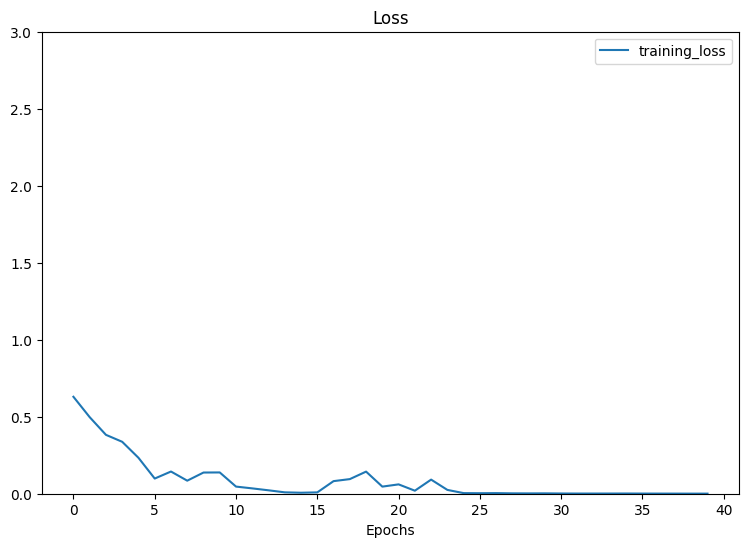

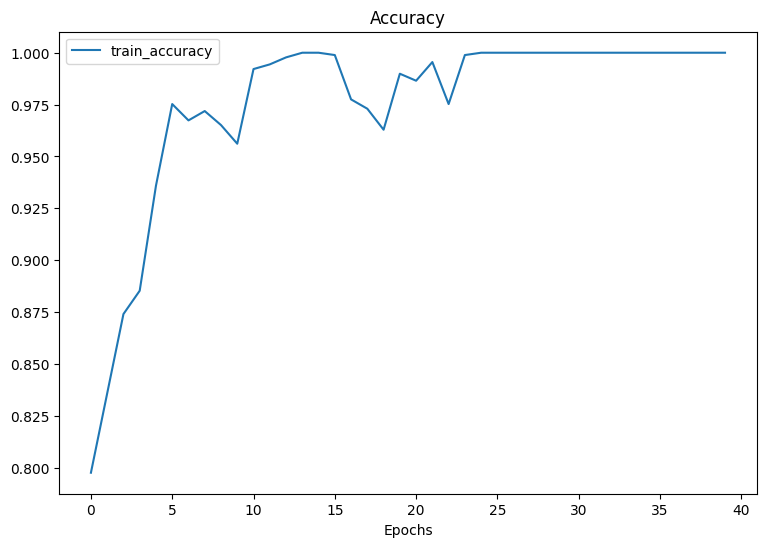

In [ ]:
# --- Train the model with the best hyperparameters and evaluate it on the test set ---

# Hyperparameters
BEST_LR = 1.1e-5 # learning rate
BEST_WD= 2e-4 # weight decay
BEST_NUM_EPOCHS = 40 # number of epochs for training
cosine_scheduler = False # Set to True if using cosine decay, False if using fixed learning rate
print(f"Using cosine decay: {cosine_scheduler}")
train_for_more_epochs = False

# Filepath to save/load the model
SAVED_MODEL_FILEPATH = "/home/diogommiranda/tese/outputs/best_model.pth"

# Load saved model or train anew
if train_for_more_epochs:
    model.load_state_dict(torch.load(SAVED_MODEL_FILEPATH, weights_only=True, map_location=device)) # load model to continue training for more epochs
    print(f"\nLoading model weights to continue training for more epochs.")
else:
    model = ResNet(
        block='basic',
        layers=[3, 4, 6, 3],
        block_inplanes=[64, 128, 256, 512],
        spatial_dims=3,
        n_input_channels=1,
        conv1_t_stride=2,
        num_classes=1,
        shortcut_type='B',
    )
    model.to(device)

# Compute class weights for the current fold
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
pos_weight_val = class_counts[0] / class_counts[1]
pos_weight_val = torch.tensor([pos_weight_val], device=device)
print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=BEST_LR, weight_decay=BEST_WD)

scheduler = None
if cosine_scheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7) # T_max=100 for 100 epochs (used in CV)

history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': []}

for epoch in tqdm(range(BEST_NUM_EPOCHS)):
    epoch_start_time = time.time()
    history['epoch'].append(epoch + 1)

    model.train()
    running_loss = 0.0
    train_pred_probs = []
    train_targets = []

    for i, (inputs, labels) in enumerate(train_data):
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        
        prob_outputs = torch.sigmoid(outputs)
        train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
        train_targets.extend(labels.detach().cpu().numpy())

    train_targets = np.array(train_targets).flatten()
    train_pred_probs = np.array(train_pred_probs).flatten()
    
    # Calculate training metrics for the epoch
    train_loss = running_loss / len(train_data.dataset)
    train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
    train_auc = roc_auc_score(train_targets, train_pred_probs)
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['train_auc'].append(train_auc)
        
    epoch_duration = time.time() - epoch_start_time
    print(f"    Epoch {epoch+1}/{BEST_NUM_EPOCHS} [{epoch_duration:.2f}s] - Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f}")
    
    if scheduler:
        scheduler.step()

# Save the model if using fixed learning rate in case we want to continue training it
if not cosine_scheduler:
    torch.save(model.state_dict(), SAVED_MODEL_FILEPATH)
    print(f"Model saved to: {SAVED_MODEL_FILEPATH}")

plot_loss_curves(history)

# Evaluate the model on the test data
model.eval()
test_running_loss = 0.0
test_pred_probs = []
test_targets = []

with torch.inference_mode():
    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
    
        prob_outputs = torch.sigmoid(outputs)
        
        test_pred_probs.extend(prob_outputs.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_targets = np.array(test_targets).flatten()
test_pred_probs = np.array(test_pred_probs).flatten()

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_data.dataset)
test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)
print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")


--- Evaluation Metrics on Test Set ---
Accuracy:    0.8326
Sensitivity: 0.6795
Specificity: 0.9161 
Balanced Accuracy (BACC): 0.7978
F1 Score (Weighted):      0.8286
Matthews Corr Coef (MCC): 0.6246
Area Under the Curve (AUC): 0.7978



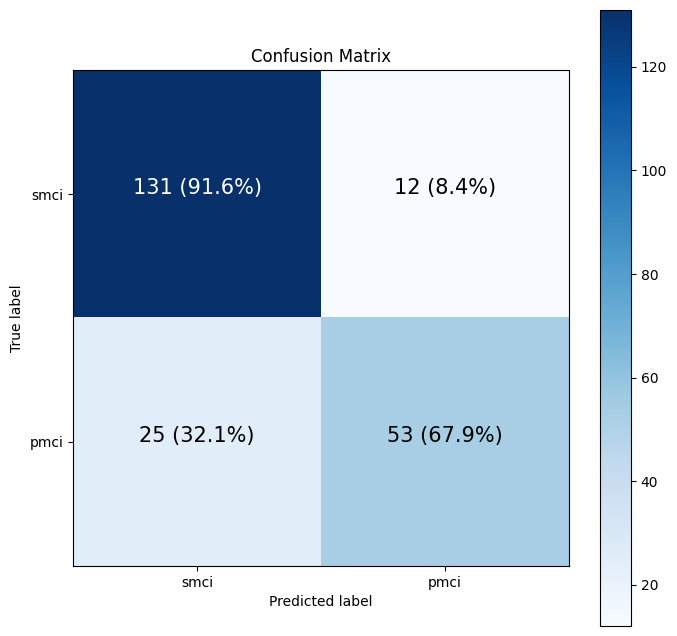

In [ ]:
y_true = test_targets.astype(int)
y_pred = test_pred_probs.round().astype(int)

# Calculate metrics
accuracy = test_acc
sensitivity = recall_score(y_true, y_pred, pos_label=1)
specificity = recall_score(y_true, y_pred, pos_label=0)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

print("\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true, y_pred, target_names, figsize=(8, 8), text_size=15)


# Save the model

In [ ]:
save_option = False # Set to True to save the model, confusion matrix, and evaluation metrics

if save_option:
    
    # Configure the right path
    if USE_MASK:
        dir1 = "masked/"
    else:
        dir1 = "full_brain/"
    if cosine_scheduler:
        dir2 = "cosine_decay/"
    else:
        dir2 = "fixed_lr/"
        
    save_model_dir = "/home/diogommiranda/tese/outputs/torch/" + dir1 + dir2 + "CROSS_VALIDATION/saved_models/" + f"LR={BEST_LR:.1e}_WD={BEST_WD:.0e}"
    print(f"Saving model to: {save_model_dir}")
    os.makedirs(save_model_dir, exist_ok=True)

    # Save the model
    torch.save(model.state_dict(), os.path.join(save_model_dir, "model.pth"))

    # Save the confusion matrix plot
    make_confusion_matrix(y_true=y_true,
                        y_pred=y_pred.round(),
                        classes=target_names,
                        figsize=(8, 8),
                        text_size=15,
                        save_dir=save_model_dir)

    # Save the test loss and accuracy and the evaluation metrics
    result_file_path = os.path.join(save_model_dir, "resultados.txt")
    with open(result_file_path, "w") as f:
        f.write(f"[{test_loss}, {test_acc}]\n\n")
        f.write("--- Evaluation Metrics on Test Set ---\n")
        f.write(f"Accuracy:    {accuracy:.4f}\n")
        f.write(f"Sensitivity: {sensitivity:.4f}\n")
        f.write(f"Specificity: {specificity:.4f}\n")
        f.write(f"Balanced Accuracy (BACC): {bacc:.4f}\n")
        f.write(f"F1 Score (Weighted):      {f1:.4f}\n")
        f.write(f"Matthews Corr Coef (MCC): {mcc:.4f}\n")
        f.write(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

Saving model to: /home/diogommiranda/tese/outputs/torch/full_brain/fixed_lr/CROSS_VALIDATION/saved_models/LR=1.1e-05_WD=2e-04
